In [1]:
import pandas
import numpy
import scipy.stats as stats
import networkx
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import pyreadstat

In [2]:
df_original, meta_original = pyreadstat.read_sav("data-covid-source.sav")
print(f"There're {len(df_original.columns)} variables in the data:")
pandas.set_option('display.max_columns', None)
# pandas.set_option("display.max_rows", None)
pandas.set_option("display.precision", 1)
display(df_original.describe(percentiles=[]).transpose())
pandas.reset_option("max_columns")
# pandas.reset_option("max_rows")
pandas.reset_option("precision")

There're 510 variables in the data:


count    mean     std    min     50%      max
Id                   547.0   400.4   234.9    1.0   389.0    832.0
ATT_1_1              547.0     3.0     0.0    3.0     3.0      3.0
ATT_1_2              547.0     6.0     0.0    6.0     6.0      6.0
TIME_1               547.0  2026.2  3907.8  221.0  1274.0  55552.0
TIME_2               547.0  2363.2  5401.8  264.0  1408.0  88447.0
...                    ...     ...     ...    ...     ...      ...
Wiedza_koronavir_t5  547.0    -0.3     0.2   -0.6    -0.3      0.2
WHO_FIZ_t4           547.0     5.9     1.7    1.0     6.0      9.0
WHO_SPOL_t4          547.0     6.2     1.7    1.0     6.5      9.0
BOGARDUS_uchodz_t4   547.0     2.7     1.1    1.0     2.6      5.0
BOGARDUS_lgbtq_t4    547.0     2.4     1.1    1.0     2.2      5.0

[504 rows x 6 columns]

In the above table there's some basic information on 510 variables measuring various psychological metrics from a longitude study of 547 people.<br>
There were 5 measurements, each one week apart from the others.<br>
The variables encode the number of measurement in their name by appending "\_t2", \_t3", ... to their name. For the first measurement "\_t1" is sometimes appended, sometimes not, depending on the variable.<br>
For some variables, not all 5 measurements are present - for example for communal narcissm ("cni" in the source data) the measurements are from week 1 and week 5 only. In the "cni" example, there are 16 variables from "cni1" to "cni16" describing various 16 metrics of communal narcissm, and are followed up with "cni1_t5" to "cni16_t5" (where "\_t5" indicates the week no. 5 of measurement taken).

The goal of this excercise is to:<br>
1. perform paired sample t-test for following measurements;
1. compute [Cohen's d - effect size value](https://en.wikipedia.org/wiki/Effect_size#Cohen's_d);
1. plot the change in time (with mean trajectories);
1. compute partial correlation networks and basic networks' metrics;
1. plot the networks (with only signifcant changes - uncorrected p>0.05);
1. plot correlogram for average absolute edge values between and within questionnaires;
1. plot basic graphs' metrics for particular measurements at different times to easily observe change (or lack of thereof);
1. compute and show in correlation matrix the Pearson's correlation of considered variables

Only selected variables are to be considered, and those are:
1. Knowledge ("wiedza");
1. Communal Narcissim ("cni");
1. Dissinfection ("odkazanie");
1. Stay-at-home ("siedz_w_domu");
1. Cleaning-hands ("mycie_rak");
1. Masks ("maseczki");
1. Threatened ("zagr_ja");
1. Dark Triad ("DT")
1. Series of WHO health metrics ("WHO_zdr", "WHO_sen", "WHO_samooc_ind", "WHO_zwiazki", "WHO_wsparcie");


In [22]:
desired_variable_names = ['cni', 'DT', 'wiedza', 'odkazanie', 'siedz_w_domu', 'mycie_rak', 'maseczki', 'zagr_ja', 'WHO']
variable_list = []

for column in df_original.columns:
    if any(d in column for d in desired_variable_names):
        variable_list.append(column)
variable_list.sort(reverse=True)

pandas.set_option('display.max_columns', None)
pandas.set_option("display.max_rows", None)
pandas.set_option("display.precision", 1)
display(df_original[variable_list].describe(percentiles=[]).transpose().head())
pandas.reset_option("max_columns")
pandas.reset_option("max_rows")
pandas.reset_option("precision")

count  mean  std  min  50%  max
zagr_ja_t4  547.0   3.1  1.0  1.0  3.0  5.0
zagr_ja     547.0   3.4  1.0  1.0  3.0  5.0
wiedza9_t5  547.0   1.8  0.4  1.0  2.0  2.0
wiedza9     547.0   0.2  0.4  0.0  0.0  1.0
wiedza8_t5  547.0   1.9  0.3  1.0  2.0  2.0

Let's match variable names from first study with second (week 4 or week 5) study:

In [4]:
varaibles_time_pairs_dict = dict()
for variable_candidate in variable_list:
    for match_candidate in variable_list:
        if variable_candidate is not match_candidate:
            if variable_candidate in match_candidate:
                varaibles_time_pairs_dict[variable_candidate] = match_candidate

# Let me correct a few wrong matches manually:
varaibles_time_pairs_dict['siedz_w_domu'] = 'siedz_w_domu_t4'
varaibles_time_pairs_dict['maseczki'] = 'maseczki_t4'
varaibles_time_pairs_dict['cni1'] = 'cni1_t5' 
varaibles_time_pairs_dict['DT1'] = 'DT1_t5'
varaibles_time_pairs_dict['mycie_rak'] = 'mycie_rak_t4'
varaibles_time_pairs_dict['odkazanie'] = 'odkazanie_t4'


For each of paired weeks of measurement for given variable, let's calculate the paired sample t-test:

In [5]:
paired_tests_dict = dict()
var_pairs_null_hypo_dict = dict()
var_pairs_alter_hypo_dict = dict()

for var_week_1, var_week_2 in varaibles_time_pairs_dict.items():
    pre = df_original[var_week_1]
    post = df_original[var_week_2]
    paired_tests_dict[f"{var_week_1}-{var_week_2}"] = stats.ttest_rel(pre, post)

print("Variable pairs for which a test for the null hypothesis that two \n(related as mentioned above) samples have identical average values holds \n(null hypothesis is NOT rejected):\n")
for var_pair, result_obj in paired_tests_dict.items():
    if result_obj.pvalue >= 0.05:
        var_pairs_null_hypo_dict[var_pair] = result_obj
        print(f"{var_pair:33} - p-value: {result_obj.pvalue:.3f}")

print("\nVariable pairs for which a test for the null hypothesis that two \nsamples have identical average values fails \n(null hypothesis IS rejected):\n")
for var_pair, result_obj in paired_tests_dict.items():
    if result_obj.pvalue < 0.05:
        var_pairs_alter_hypo_dict[var_pair] = result_obj
        print(f"{var_pair:33} - p-value: {result_obj.pvalue:.3f}, statistic: {result_obj.statistic:.3f}")

Variable pairs for which a test for the null hypothesis that two 
(related as mentioned above) samples have identical average values holds 
(null hypothesis is NOT rejected):

cni9-cni9_t5                      - p-value: 0.721
cni8-cni8_t5                      - p-value: 0.118
cni7-cni7_t5                      - p-value: 0.422
cni5-cni5_t5                      - p-value: 1.000
cni4-cni4_t5                      - p-value: 0.162
cni3-cni3_t5                      - p-value: 0.075
cni16-cni16_t5                    - p-value: 0.485
cni14-cni14_t5                    - p-value: 1.000
cni11-cni11_t5                    - p-value: 0.754
WHO_zwiazki-WHO_zwiazki_t4        - p-value: 0.583
WHO_wsparcie-WHO_wsparcie_t4      - p-value: 0.734
WHO_sen-WHO_sen_t4                - p-value: 0.223
WHO_samooc_kol-WHO_samooc_kol_t4  - p-value: 0.071
WHO_samooc_ind-WHO_samooc_ind_t4  - p-value: 0.247
WHO_SPOL-WHO_SPOL_t4              - p-value: 0.566
NAR_DT-NAR_DT_t5                  - p-value: 0.833
DT8-DT8_

Let's calculate the Cohen's d value - the difference between two means divided by a standard deviation for the data.<br>
$d = \frac{\bar{x}_1 - \bar{x}_2}{s}$
, where s is [pooled variance](https://en.wikipedia.org/wiki/Pooled_variance):<br>
$s = \sqrt{\frac{(n_1 - 1)s^2_1 + (n_2 - 1)s^2_2}{n_1 + n_2 - 2}}$
<br>
and where $s^2 = \frac{1}{n  - 1}\sum_{i=1}^{n}(x_i - \bar{x})^2$<br>
A positive d indicates that the first mean is higher. In contrast, a negative d indicates that the second mean is higher. A lower Cohen's d indicates the necessity of larger sample sizes, and vice versa - [Wikipedia](https://en.wikipedia.org/wiki/Effect_size#Cohen's_d)

In [6]:
import statistics

d_value_per_pair_dict = dict()
s_sqr = lambda l, a: (1/(len(l) - 1)) * (sum(map(lambda x: (x - a) ** 2, l)))
effect_size = lambda x: "very small" if abs(x)<0.01 else "small" if abs(x)<0.2 else "medium" if abs(x)<0.5 else "large" if abs(x)<0.8 else "very large" if abs(x)<1.2 else "huge"

for var_week_1, var_week_2 in varaibles_time_pairs_dict.items():
    s_sqr_week_1 = s_sqr(df_original[var_week_1], statistics.mean(df_original[var_week_1]))
    s_sqr_week_2 = s_sqr(df_original[var_week_2], statistics.mean(df_original[var_week_2]))
    len_week_1 = len(df_original[var_week_1])
    len_week_2 = len(df_original[var_week_2])
    pooled_var_s = (((len_week_1 - 1) * s_sqr_week_1 + (len_week_2 - 1) * s_sqr_week_2) / (len_week_1 + len_week_2 - 2)) ** 0.5
    d_value_per_pair_dict[f"{var_week_1}-{var_week_2}"] = (statistics.mean(df_original[var_week_1]) - statistics.mean(df_original[var_week_2])) / pooled_var_s

for var_pair in var_pairs_alter_hypo_dict.keys():
    print(f"{var_pair:30}: {d_value_per_pair_dict[var_pair]:6.3f} ({effect_size(d_value_per_pair_dict[var_pair])})")

zagr_ja-zagr_ja_t4            :  0.355 (medium)
wiedza9-wiedza9_t5            : -4.007 (huge)
wiedza8-wiedza8_t5            : -4.975 (huge)
wiedza7-wiedza7_t5            : -2.777 (huge)
wiedza6-wiedza6_t5            : -2.320 (huge)
wiedza5-wiedza5_t5            : -5.666 (huge)
wiedza4-wiedza4_t5            : -4.378 (huge)
wiedza3-wiedza3_t5            : -4.238 (huge)
wiedza2-wiedza2_t5            : -0.624 (large)
wiedza1-wiedza1_t5            : -3.745 (huge)
siedz_w_domu-siedz_w_domu_t4  :  0.767 (large)
odkazanie-odkazanie_t4        :  0.228 (medium)
mycie_rak-mycie_rak_t4        :  0.404 (medium)
maseczki-maseczki_t4          : -0.317 (medium)
cni6-cni6_t5                  :  0.110 (small)
cni2-cni2_t5                  :  0.086 (small)
cni15-cni15_t5                :  0.102 (small)
cni13-cni13_t5                :  0.106 (small)
cni12-cni12_t5                :  0.100 (small)
cni10-cni10_t5                :  0.118 (small)
cni1-cni1_t5                  : -0.110 (small)
WHO_zdr-WHO_zdr_t

For graph plotting purpose, let me reshape the data more suitably (into one dataframe, organised by test participants instead of tests):

In [7]:
new_df_column_names = ['Id', 'test', 'before', 'after']
paired_plot_data_df = pandas.DataFrame(columns=new_df_column_names)
paired_plot_data_list = []

index = 0
for _, row in df_original.iterrows():
    for var_week_1, var_week_2 in varaibles_time_pairs_dict.items():
        index += 1
        new_row = {'Id': row['Id'],
                   'test': var_week_1,
                   'before': row[var_week_1],
                   'after': row[var_week_2]
                  }
        paired_plot_data_list.append(new_row)
paired_plot_data_df = pandas.DataFrame.from_records(paired_plot_data_list)
display(paired_plot_data_df[paired_plot_data_df['Id'] == 7])

Id            test  before  after
0   7.0         zagr_ja     5.0    1.0
1   7.0         wiedza9     0.0    2.0
2   7.0         wiedza8     0.0    2.0
3   7.0         wiedza7     0.0    1.0
4   7.0         wiedza6     0.0    1.0
5   7.0         wiedza5     0.0    2.0
6   7.0         wiedza4     0.0    2.0
7   7.0         wiedza3     0.0    2.0
8   7.0         wiedza2     1.0    1.0
9   7.0         wiedza1     0.0    2.0
10  7.0    siedz_w_domu     2.0    1.0
11  7.0       odkazanie     4.0    1.0
12  7.0       mycie_rak     4.0    4.0
13  7.0        maseczki     2.0    1.0
14  7.0            cni9     1.0    1.0
15  7.0            cni8     1.0    1.0
16  7.0            cni7     1.0    1.0
17  7.0            cni6     1.0    1.0
18  7.0            cni5     1.0    1.0
19  7.0            cni4     1.0    1.0
20  7.0            cni3     1.0    1.0
21  7.0            cni2     1.0    1.0
22  7.0           cni16     1.0    1.0
23  7.0           cni15     1.0    1.0
24  7.0           cni14     1.0    1.0
25  7.0           cni13     1.0    1.0
26  7.0           cni12     1.0    1.0
27  7.0           cni11     1.0    1.0
28  7.0           cni10     1.0    7.0
29  7.0            cni1     1.0    1.0
30  7.0     WHO_zwiazki     1.0    1.0
31  7.0         WHO_zdr     9.0    9.0
32  7.0    WHO_wsparcie     1.0    1.0
33  7.0         WHO_sen     9.0    9.0
34  7.0  WHO_samooc_kol     1.0    1.0
35  7.0  WHO_samooc_ind     9.0    9.0
36  7.0        WHO_SPOL     1.0    1.0
37  7.0         WHO_FIZ     9.0    9.0
38  7.0        PSYCH_DT     5.0    3.0
39  7.0          NAR_DT     5.0    1.0
40  7.0         MACH_DT     5.0    1.0
41  7.0             DT9     5.0    1.0
42  7.0             DT8     5.0    1.0
43  7.0             DT7     5.0    1.0
44  7.0             DT6     5.0    1.0
45  7.0             DT5     5.0    1.0
46  7.0             DT4     5.0    1.0
47  7.0             DT3     5.0    1.0
48  7.0             DT2     5.0    5.0
49  7.0            DT12     5.0    1.0
50  7.0            DT11     5.0    1.0
51  7.0            DT10     5.0    1.0
52  7.0             DT1     5.0    5.0

The next step is to plot the mean trajectories of change.
On high level, the changes we're interested in are:
1. knowledge ("wiedza") (9 questions - range from 0 to 2);
1. threat-self ("zagr_ja") (range from 1 to 5);
1. Hygiene behavior related questions:
    1. stay-at-home ("siedz_w_domu") (range from 1 to 4),
    1. dissinfection ("odkazanie") (range from 1 to 4),
    1. washing hands ("mycie_rak") (range from 1 to 4),
    1. Masks ("maseczki") (range from 1 to 4),
1. Communal Narcissim ("cni") (7 questions) (range from 1 to 7);
1. Dark Triad ("DT") (7 questions) (range from 1 to 5);
1. WHO-related ("WHO") (2 questions) (range from 1 to 9)

Aside from the measured variables, there're also some demographic variables:
1. age,
1. sex,
1. kohort,
1. education

The input data is just a measured answer for particular questions in a survey at some two points in time. In case of knowledge-related variables the data are 0 or 1 for first measurement and 1 or 2 for the second measurement, so I can't plot this as-is since it won't be meaningful. Let me plot the changes in sum of answers for knowledge, communal narcissim and dark triad for sexes:

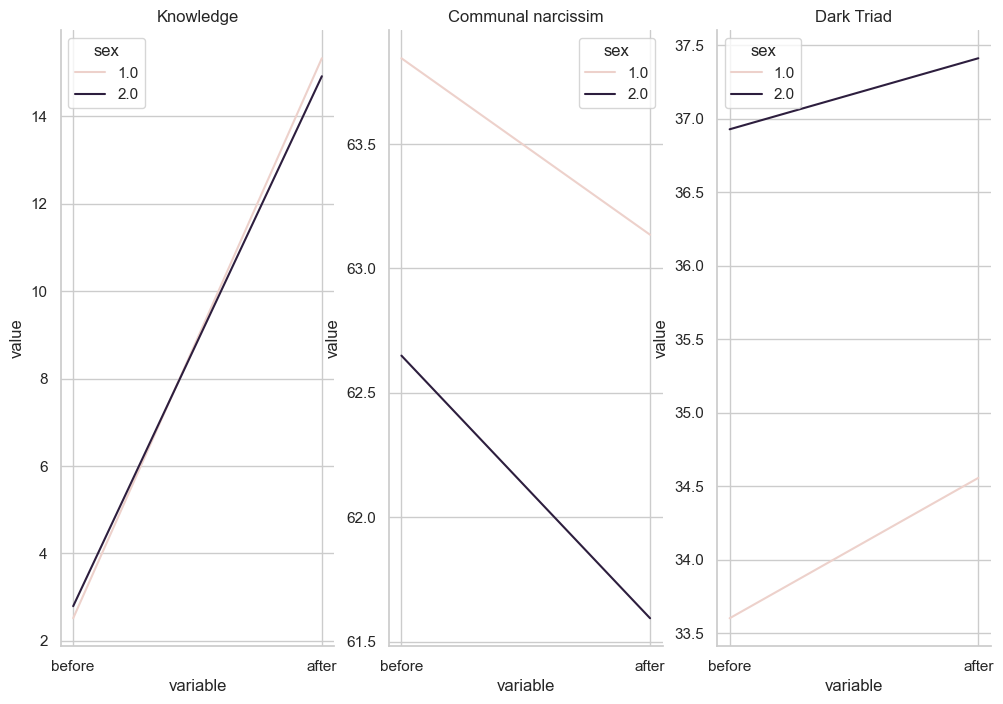

In [8]:
aggregated_knowledge_df = pandas.melt(paired_plot_data_df[paired_plot_data_df["test"].str.contains('wiedza')].groupby("Id")[["before", "after"]].sum(), value_vars=['before', 'after'], ignore_index=False).join(df_original[["Id", "sex", "age", "wyksztalcenie", "przynal_rel"]].set_index('Id'), on='Id', how='left', lsuffix='_caller', rsuffix='_other')
aggregated_narcissism_df = pandas.melt(paired_plot_data_df[paired_plot_data_df["test"].str.contains('cni')].groupby("Id")[["before", "after"]].sum(), value_vars=['before', 'after'], ignore_index=False).join(df_original[["Id", "sex", "age", "wyksztalcenie", "przynal_rel"]].set_index('Id'), on='Id', how='left', lsuffix='_caller', rsuffix='_other')
aggregated_darktriad_df = pandas.melt(paired_plot_data_df[paired_plot_data_df["test"].str.contains('DT')].groupby("Id")[["before", "after"]].sum(), value_vars=['before', 'after'], ignore_index=False).join(df_original[["Id", "sex", "age", "wyksztalcenie", "przynal_rel"]].set_index('Id'), on='Id', how='left', lsuffix='_caller', rsuffix='_other')

seaborn.set()
seaborn.set_style("whitegrid")

fig, axes = plt.subplots(1, 3, figsize=(12, 8))
axes[0].set_title('Knowledge')
axes[1].set_title('Communal narcissim')
axes[2].set_title('Dark Triad')
seaborn.despine(fig)

seaborn.lineplot(ax=axes[0], data=aggregated_knowledge_df, x="variable", y="value", hue="sex", estimator="mean", errorbar=None)
seaborn.lineplot(ax=axes[1], data=aggregated_narcissism_df, x="variable", y="value", hue="sex", estimator="mean", errorbar=None)
seaborn.lineplot(ax=axes[2], data=aggregated_darktriad_df, x="variable", y="value", hue="sex", estimator="mean", errorbar=None)

plt.show()

In [9]:
individuals_knowledge_data = {'time': ['before', 'after']}
individuals_cni_data = {'time': ['before', 'after']} # no chain assigment since dict is mutable
individuals_dt_data = {'time': ['before', 'after']}
individuals_health_data = {'time': ['before', 'after']}

ids = df_original['Id'].tolist()
for person_no in ids:
    individuals_knowledge_data[person_no] = [sum(paired_plot_data_df[(paired_plot_data_df["Id"] == person_no) & paired_plot_data_df["test"].str.contains('wiedza')]["before"].tolist()), sum(paired_plot_data_df[(paired_plot_data_df["Id"] == person_no) & paired_plot_data_df["test"].str.contains('wiedza')]["after"].tolist())]
    individuals_cni_data[person_no] = [sum(paired_plot_data_df[(paired_plot_data_df["Id"] == person_no) & paired_plot_data_df["test"].str.contains('cni')]["before"].tolist()), sum(paired_plot_data_df[(paired_plot_data_df["Id"] == person_no) & paired_plot_data_df["test"].str.contains('cni')]["after"].tolist())]
    individuals_dt_data[person_no] = [sum(paired_plot_data_df[(paired_plot_data_df["Id"] == person_no) & paired_plot_data_df["test"].str.contains('DT')]["before"].tolist()), sum(paired_plot_data_df[(paired_plot_data_df["Id"] == person_no) & paired_plot_data_df["test"].str.contains('DT')]["after"].tolist())]
    individuals_health_data[person_no] = [sum(paired_plot_data_df[(paired_plot_data_df["Id"] == person_no) & paired_plot_data_df["test"].str.contains('WHO')]["before"].tolist()), sum(paired_plot_data_df[(paired_plot_data_df["Id"] == person_no) & paired_plot_data_df["test"].str.contains('WHO')]["after"].tolist())]

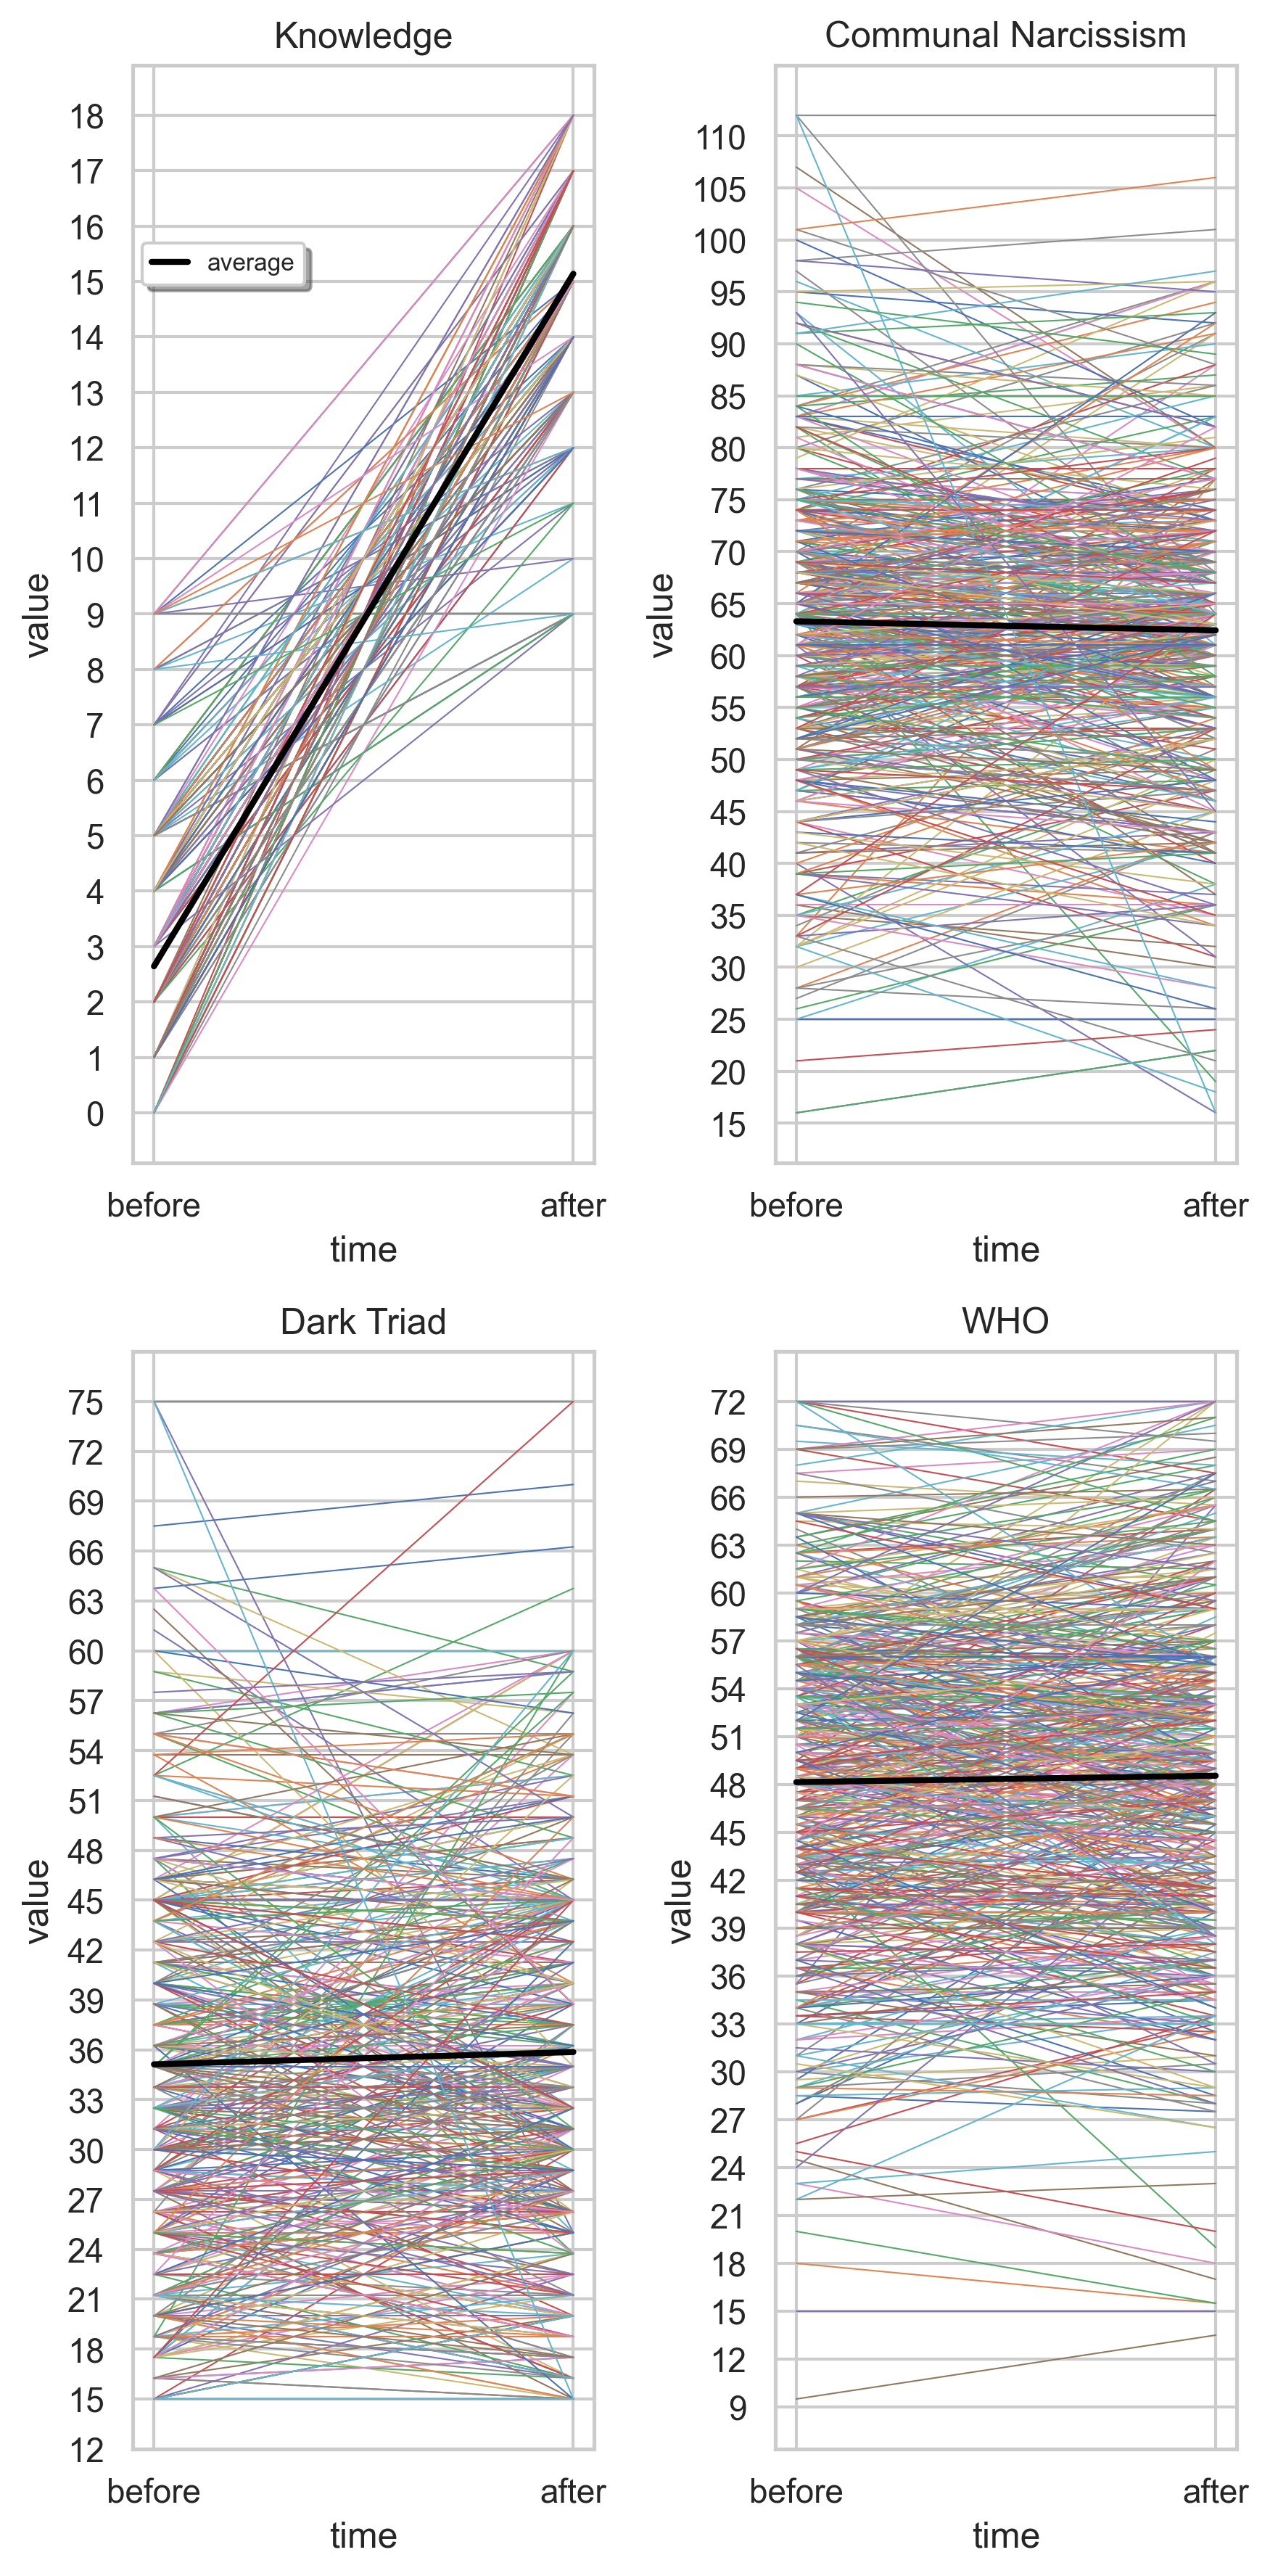

In [10]:
seaborn.set_style("whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(6, 12), dpi=300)

kl_axes = seaborn.lineplot(x='time', y='value', hue='variable', legend=False, linewidth=0.5, data=pandas.melt(pandas.DataFrame(individuals_knowledge_data), ['time']), palette="deep", ax=axs[0, 0])
kl_axes.set_title("Knowledge")
kl_axes.set_yticks([n for n in range(0, 9*2+1)])
kl_axes.plot([0, 1], [sum(paired_plot_data_df[paired_plot_data_df["test"].str.contains('wiedza')]["before"].tolist())/len(ids), sum(paired_plot_data_df[paired_plot_data_df["test"].str.contains('wiedza')]["after"].tolist())/len(ids)], color="black", linewidth=2, label="average")
kl_axes.legend(shadow=True, loc=(0.02, 0.8), handlelength=1.5, fontsize=8)

cni_axes = seaborn.lineplot(x='time', y='value', hue='variable', legend=False, linewidth=0.5, data=pandas.melt(pandas.DataFrame(individuals_cni_data), ['time']), palette="deep", ax=axs[0, 1])
cni_axes.set_title("Communal Narcissism")
cni_axes.set_yticks([n for n in range(0, 16*7+3, 5)])
cni_axes.plot([0, 1], [sum(paired_plot_data_df[paired_plot_data_df["test"].str.contains('cni')]["before"].tolist())/len(ids), sum(paired_plot_data_df[paired_plot_data_df["test"].str.contains('cni')]["after"].tolist())/len(ids)], color="black", linewidth=2, label="average")

dt_axes = seaborn.lineplot(x='time', y='value', hue='variable', legend=False, linewidth=0.5, data=pandas.melt(pandas.DataFrame(individuals_dt_data), ['time']), palette="deep", ax=axs[1, 0])
dt_axes.set_title("Dark Triad")
dt_axes.set_yticks([n for n in range(0, 15*5+1, 3)])
dt_axes.plot([0, 1], [sum(paired_plot_data_df[paired_plot_data_df["test"].str.contains('DT')]["before"].tolist())/len(ids), sum(paired_plot_data_df[paired_plot_data_df["test"].str.contains('DT')]["after"].tolist())/len(ids)], color="black", linewidth=2, label="average")

h_axes = seaborn.lineplot(x='time', y='value', hue='variable', legend=False, linewidth=0.5, data=pandas.melt(pandas.DataFrame(individuals_health_data), ['time']), palette="deep", ax=axs[1, 1])
h_axes.set_title("WHO")
h_axes.set_yticks([n for n in range(0, 8*9+1, 3)])
h_axes.plot([0, 1], [sum(paired_plot_data_df[paired_plot_data_df["test"].str.contains('WHO')]["before"].tolist())/len(ids), sum(paired_plot_data_df[paired_plot_data_df["test"].str.contains('WHO')]["after"].tolist())/len(ids)], color="black", linewidth=2, label="average")

plt.tight_layout()
plt.show()

With computed paired sample t-test, Cohen's d values for effect size, and plotted the time changes with mean trajectories, let's work on visualising the questionaires' items relations with partial correlation networks. 

"In probability theory and statistics, partial correlation measures the degree of association between two random variables, with the effect of a set of controlling random variables removed. When determining the numerical relationship between two variables of interest, using their correlation coefficient will give misleading results if there is another confounding variable that is numerically related to both variables of interest. This misleading information can be avoided by controlling for the confounding variable, which is done by computing the partial correlation coefficient." - [Wikipedia](https://en.wikipedia.org/wiki/Partial_correlation) <br>
Partial correlation networks have also been called
concentration graphs (Cox & Wermuth, 1994) or Gaussian
graphical models (Lauritzen, 1996), and are part of a more
general class of statistical models termed pairwise Markov
random fields (see, e.g., Koller & Friedman, 2009 and Murphy,
2012 for an extensive description of pairwise Markov random
fields) - [Epskamp, 2018](https://eiko-fried.com/wp-content/uploads/Epskamp-Fried-2018-Tutorial-partial-corr.pdf)

In calculating the partial correlation, I'll use the inverse of a variance–covariance matrix described in _[Epskamp, S., & Fried, E. I. (2018). A tutorial on regularized partial correlation networks. Psychological Methods, 23(4), 617–634.](https://eiko-fried.com/wp-content/uploads/Epskamp-Fried-2018-Tutorial-partial-corr.pdf)_

In [21]:
selected_data = df_original[variable_list]
data_time_one = selected_data.filter(regex='^(?!.*_t).*$')
data_time_two = selected_data.filter(regex='.*_t.*')

cov_matrix_time_one = data_time_one.cov()
cov_matrix_time_two = data_time_two.cov()

# Moore–Penrose inverse
inverse_cov_matrix_time_one = pandas.DataFrame(numpy.linalg.pinv(cov_matrix_time_one.values), cov_matrix_time_one.columns, cov_matrix_time_one.index)
inverse_cov_matrix_time_two = pandas.DataFrame(numpy.linalg.pinv(cov_matrix_time_two.values), cov_matrix_time_two.columns, cov_matrix_time_two.index)

partial_corr_matrix_time_one = pandas.DataFrame(0, index=inverse_cov_matrix_time_one.index, columns=inverse_cov_matrix_time_one.columns)
for i in range(inverse_cov_matrix_time_one.shape[0]):
    for j in range(inverse_cov_matrix_time_one.shape[1]):
        if i != j:
            partial_corr_matrix_time_one.iloc[i, j] = -inverse_cov_matrix_time_one.iloc[i, j] / numpy.sqrt(inverse_cov_matrix_time_one.iloc[i, i] * inverse_cov_matrix_time_one.iloc[j, j])
        else:
            partial_corr_matrix_time_one.iloc[i, j] = 1.0

partial_corr_matrix_time_two = pandas.DataFrame(0, index=inverse_cov_matrix_time_two.index, columns=inverse_cov_matrix_time_two.columns)
for i in range(inverse_cov_matrix_time_two.shape[0]):
    for j in range(inverse_cov_matrix_time_two.shape[1]):
        if i != j:
            partial_corr_matrix_time_two.iloc[i, j] = -inverse_cov_matrix_time_two.iloc[i, j] / numpy.sqrt(inverse_cov_matrix_time_two.iloc[i, i] * inverse_cov_matrix_time_two.iloc[j, j])
        else:
            partial_corr_matrix_time_two.iloc[i, j] = 1.0

display(partial_corr_matrix_time_one.head())
display(partial_corr_matrix_time_two.head())


zagr_ja   wiedza9   wiedza8   wiedza7   wiedza6   wiedza5   wiedza4  \
zagr_ja  1.000000  0.012044  0.120267  0.029345 -0.045491 -0.072079  0.045194   
wiedza9  0.012044  1.000000  0.144890  0.060866 -0.000938  0.101783  0.122554   
wiedza8  0.120267  0.144890  1.000000  0.079807  0.006547  0.135038  0.161204   
wiedza7  0.029345  0.060866  0.079807  1.000000  0.141511  0.299049  0.062035   
wiedza6 -0.045491 -0.000938  0.006547  0.141511  1.000000  0.019230  0.091617   

          wiedza3   wiedza2   wiedza1  ...       DT7       DT6       DT5  \
zagr_ja  0.042238 -0.021885 -0.047241  ...  0.014695 -0.070934  0.094963   
wiedza9  0.064540 -0.023358  0.044512  ...  0.024863  0.099182 -0.061945   
wiedza8  0.097745  0.010990  0.060476  ...  0.017617  0.002376 -0.055710   
wiedza7  0.117848  0.012017  0.016444  ...  0.030095 -0.066962  0.062697   
wiedza6  0.143203  0.181892  0.023081  ...  0.025011 -0.058956  0.071590   

              DT4       DT3       DT2      DT12      DT11      DT10       DT1  
zagr_ja  0.014915  0.050149  0.024965 -0.121630  0.069143  0.039667 -0.049118  
wiedza9 -0.079745  0.071939  0.013015 -0.060661 -0.025521  0.028875  0.033072  
wiedza8 -0.033462 -0.048171  0.006205  0.047997 -0.014637  0.021978  0.055421  
wiedza7  0.080345 -0.014537 -0.010334  0.014300 -0.037781 -0.023076  0.019868  
wiedza6 -0.021510  0.015593  0.029626  0.009060 -0.008737  0.108329 -0.065163  

[5 rows x 57 columns]

zagr_ja_t4  wiedza9_t5  wiedza8_t5  wiedza7_t5  wiedza6_t5  \
zagr_ja_t4    1.000000    0.007326   -0.063176   -0.011453   -0.028192   
wiedza9_t5    0.007326    1.000000    0.180805    0.145587   -0.018821   
wiedza8_t5   -0.063176    0.180805    1.000000    0.055529    0.086504   
wiedza7_t5   -0.011453    0.145587    0.055529    1.000000   -0.053187   
wiedza6_t5   -0.028192   -0.018821    0.086504   -0.053187    1.000000   

            wiedza5_t5  wiedza4_t5  wiedza3_t5  wiedza2_t5  wiedza1_t5  ...  \
zagr_ja_t4   -0.037877   -0.074488    0.007235   -0.004954    0.069221  ...   
wiedza9_t5   -0.018645    0.006025    0.052510   -0.071346    0.099928  ...   
wiedza8_t5    0.078913    0.158546    0.136258    0.070590    0.001163  ...   
wiedza7_t5    0.067888   -0.051319    0.045853    0.099983    0.035502  ...   
wiedza6_t5    0.182996    0.022710   -0.001482    0.166548    0.072188  ...   

              DT7_t5    DT6_t5    DT5_t5    DT4_t5    DT3_t5    DT2_t5  \
zagr_ja_t4 -0.089914 -0.022661  0.065910  0.098294  0.018720 -0.044280   
wiedza9_t5 -0.109869  0.054497  0.007541  0.012494  0.017058  0.016760   
wiedza8_t5  0.060104 -0.021049 -0.018784 -0.021334 -0.095272  0.103528   
wiedza7_t5  0.045228 -0.104994  0.012580  0.013479 -0.036557 -0.019719   
wiedza6_t5  0.001772 -0.008691 -0.011102  0.066576  0.001427 -0.035326   

              DT1_t5   DT12_t5   DT11_t5   DT10_t5  
zagr_ja_t4  0.035274 -0.070737  0.038515 -0.004838  
wiedza9_t5 -0.008711 -0.029661 -0.037051 -0.039545  
wiedza8_t5 -0.051356 -0.033473 -0.039775 -0.005391  
wiedza7_t5  0.061820 -0.019293  0.079653 -0.004205  
wiedza6_t5 -0.012224  0.054794 -0.017975 -0.095785  

[5 rows x 58 columns]

With partial correlation matrixes computed for the measurements in time 1 and 2, let me:
1. plot the networks;
1. plot basic graphs' metrics (global strength, edge values, nodal strength centrality and bridge centrality);
1. display correlation matrix of the considered variables